In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import json

In [3]:
# Image size and batch size
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_path = 'C:/Users/AJ/OneDrive/Desktop/school/Neural Networks and Deep Learning/Weeds and Crops Classification/dataset_2_split/train'
val_path = 'C:/Users/AJ/OneDrive/Desktop/school/Neural Networks and Deep Learning/Weeds and Crops Classification/dataset_2_split/validation'
test_path = 'C:/Users/AJ/OneDrive/Desktop/school/Neural Networks and Deep Learning/Weeds and Crops Classification/dataset_2_split/test'

In [4]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_data = train_datagen.flow_from_directory(train_path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='sparse')
val_data = val_test_datagen.flow_from_directory(val_path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='sparse')
test_data = val_test_datagen.flow_from_directory(test_path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='sparse', shuffle=False)

Found 6407 images belonging to 12 classes.
Found 1368 images belonging to 12 classes.
Found 1369 images belonging to 12 classes.


In [6]:
# Simple CNN Model Definition
def build_simple_cnn(input_shape=(128, 128, 3), num_classes=12):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),  # Additional layer
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        layers.Dense(256, activation='relu'),  # Increased neurons
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

simple_cnn_model = build_simple_cnn()

In [7]:
simple_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

In [6]:
history_cnn = simple_cnn_model.fit(train_data, validation_data=val_data, epochs=50)

Epoch 1/50
201/201 [==============================] - 93s 426ms/step - loss: 2.3213 - accuracy: 0.1661 - val_loss: 2.0469 - val_accuracy: 0.2712
Epoch 2/50
201/201 [==============================] - 42s 209ms/step - loss: 1.8643 - accuracy: 0.3161 - val_loss: 1.6531 - val_accuracy: 0.4262
Epoch 3/50
201/201 [==============================] - 40s 200ms/step - loss: 1.6380 - accuracy: 0.4135 - val_loss: 1.3593 - val_accuracy: 0.5219
Epoch 4/50
201/201 [==============================] - 41s 202ms/step - loss: 1.4449 - accuracy: 0.4885 - val_loss: 1.4419 - val_accuracy: 0.4635
Epoch 5/50
201/201 [==============================] - 41s 203ms/step - loss: 1.3502 - accuracy: 0.5254 - val_loss: 1.1695 - val_accuracy: 0.5958
Epoch 6/50
201/201 [==============================] - 41s 204ms/step - loss: 1.2528 - accuracy: 0.5669 - val_loss: 1.1774 - val_accuracy: 0.5987
Epoch 7/50
201/201 [==============================] - 45s 224ms/step - loss: 1.1869 - accuracy: 0.5894 - val_loss: 0.9877 - val_ac

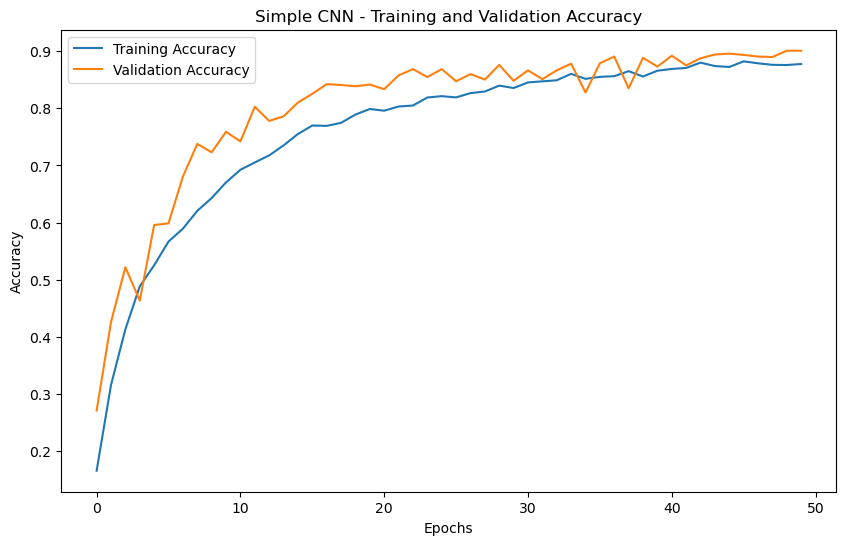

In [7]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Simple CNN - Training and Validation Accuracy')
plt.show()

In [8]:
# Evaluate on Test Data
test_loss, test_accuracy = simple_cnn_model.evaluate(test_data)
print(f'Simple CNN Test Accuracy: {test_accuracy * 100:.2f}%')

43/43 [==============================] - 9s 206ms/step - loss: 0.2841 - accuracy: 0.8926
Simple CNN Test Accuracy: 89.26%


43/43 [==============================] - 8s 182ms/step


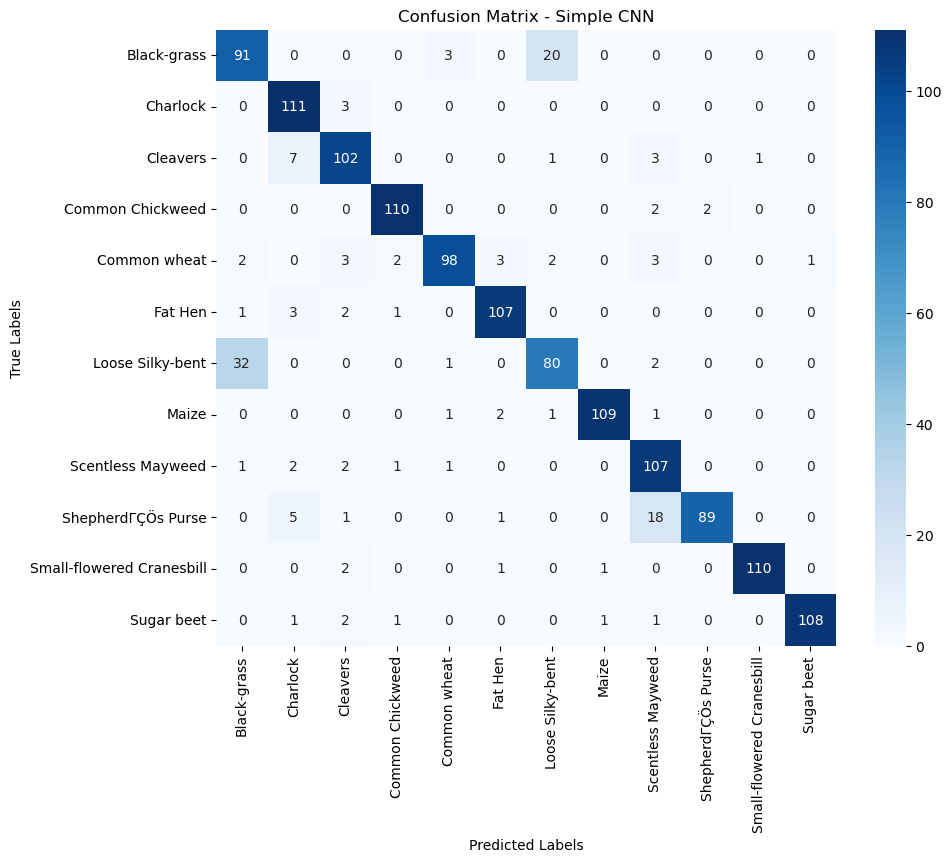

In [9]:
# Get Predictions
predictions = np.argmax(simple_cnn_model.predict(test_data), axis=1)

# Use test_data.labels directly if it's already in integer format
true_classes = test_data.labels  # Assuming test_data.labels is 1-dimensional

# Class labels (ensure this matches your dataset's class indices)
class_labels = list(test_data.class_indices.keys())

# Plot Confusion Matrix
cm = confusion_matrix(true_classes, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Simple CNN')
plt.show()

In [10]:
# Print Classification Report
print("Classification Report for Simple CNN")
print(classification_report(true_classes, predictions, target_names=class_labels))

Classification Report for Simple CNN
                           precision    recall  f1-score   support

              Black-grass       0.72      0.80      0.76       114
                 Charlock       0.86      0.97      0.91       114
                 Cleavers       0.87      0.89      0.88       114
         Common Chickweed       0.96      0.96      0.96       114
             Common wheat       0.94      0.86      0.90       114
                  Fat Hen       0.94      0.94      0.94       114
         Loose Silky-bent       0.77      0.70      0.73       115
                    Maize       0.98      0.96      0.97       114
        Scentless Mayweed       0.78      0.94      0.85       114
       ShepherdΓÇÖs Purse       0.98      0.78      0.87       114
Small-flowered Cranesbill       0.99      0.96      0.98       114
               Sugar beet       0.99      0.95      0.97       114

                 accuracy                           0.89      1369
                macro a

In [11]:
# Save Model
simple_cnn_model.save("simple_cnn_model.h5")
print("Simple CNN model saved as 'simple_cnn_model.h5'")

Simple CNN model saved as 'simple_cnn_model.h5'


In [12]:
# Save Metadata
metadata = {
    "train_accuracy": history_cnn.history['accuracy'][-1],  # Last epoch's training accuracy
    "val_accuracy": history_cnn.history['val_accuracy'][-1],  # Last epoch's validation accuracy
    "test_accuracy": test_accuracy,  # Test accuracy
    "num_classes": len(train_data.class_indices),  # Number of classes
    "class_indices": train_data.class_indices
}

# Save metadata as a JSON file
with open("simple_cnn_metadata.json", "w") as metadata_file:
    json.dump(metadata, metadata_file, indent=4)

print("Simple CNN metadata saved as 'simple_cnn_metadata.json'")

Simple CNN metadata saved as 'simple_cnn_metadata.json'
